Обучить модель классификации изображение на 2 класса. 

Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard.

Задание засчитывается при значениях метрики Log Loss меньше 0.3

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

import io, pickle, zipfile
from zipfile import ZipFile

import os
from random import shuffle
from glob import glob

import re


print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('E:/обучение/Netology/Введение в компьютерное зрение/4. Обучение сверточной сети на практике/train/*.jpg')
test_files = glob('E:/обучение/Netology/Введение в компьютерное зрение/4. Обучение сверточной сети на практике/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

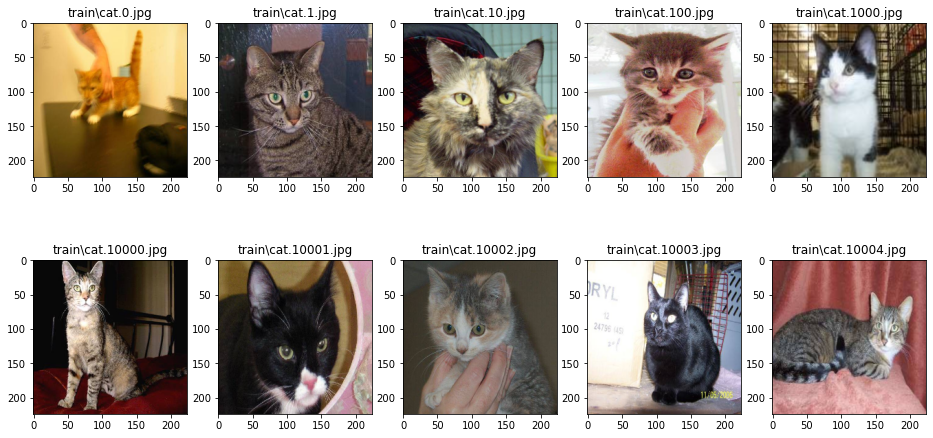

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
# Добавим полносвязный слой базовой модели

for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, # один выход (бинарная классификация)
                          activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [9]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
val_samples = 10  # число изображений в валидационной выборке

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], batch_size=32))
train_data = fit_generator(train_files[val_samples:])

model.fit(train_data,
          steps_per_epoch=10,
          epochs=100,
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 16s 2s/step - loss: 0.5324 - accuracy: 0.7563 - val_loss: 0.7590 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - 16s 2s/step - loss: 0.4301 - accuracy: 0.7906 - val_loss: 0.5414 - val_accuracy: 0.9000
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 0.3361 - accuracy: 0.8406 - val_loss: 0.1659 - val_accuracy: 0.9000
Epoch 4/100
10/10 [==============================] - 16s 2s/step - loss: 0.3526 - accuracy: 0.8469 - val_loss: 0.1460 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 16s 2s/step - loss: 0.2921 - accuracy: 0.8656 - val_loss: 0.1515 - val_accuracy: 0.9000
Epoch 6/100
10/10 [==============================] - 15s 2s/step - loss: 0.2767 - accuracy: 0.8875 - val_loss: 0.1767 - val_accuracy: 0.9000
Epoch 7/100
10/10 [==============================] - 15s 2s/step - loss: 0.3221 - accuracy: 0.8562 - val_loss: 0.2309 - val_accuracy: 0.9000
Epoch 8/100
1

In [14]:
# Предсказания на test

test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

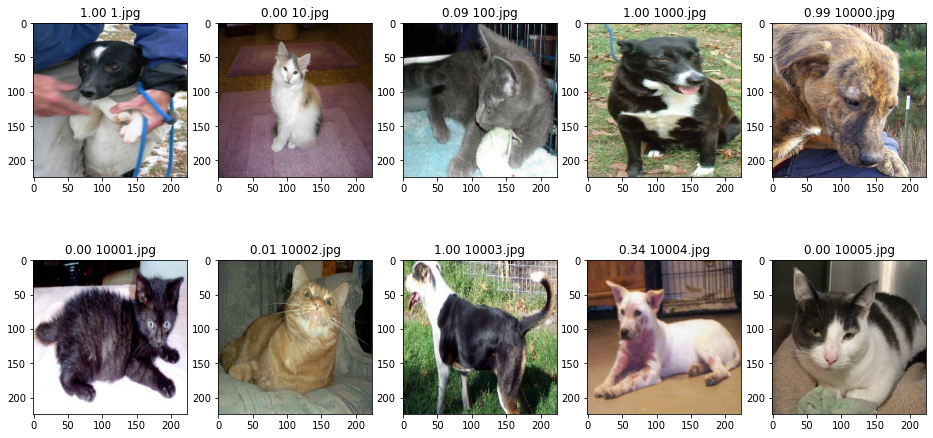

In [15]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [16]:
import re

with open('submit_vgg16.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))